In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt

In [5]:
import tensorflow as tf

In [6]:
import tensorflow_hub as hub

from tensorflow.keras import layers

In [7]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [8]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

In [9]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


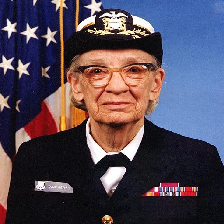

In [10]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [11]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [12]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [13]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

In [14]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

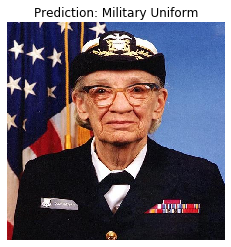

In [15]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [16]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

In [17]:
str(data_root)

'/home/kevin/.keras/datasets/flower_photos'

In [18]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [19]:
for image_batch, label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [20]:
label_batch

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [19]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [21]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['picket fence', 'daisy', 'daisy', 'daisy', 'picket fence',
       'cardoon', 'daisy', "jack-o'-lantern", 'daisy', 'daisy',
       'artichoke', 'greenhouse', 'daisy', 'pinwheel', 'picket fence',
       'earthstar', 'picket fence', 'Bedlington terrier',
       'butternut squash', 'pinwheel', 'fountain', 'vase', 'acorn',
       'earthstar', 'vase', 'mushroom', 'swab', 'pillow', 'pot', 'hip',
       'daisy', 'daisy'], dtype='<U30')

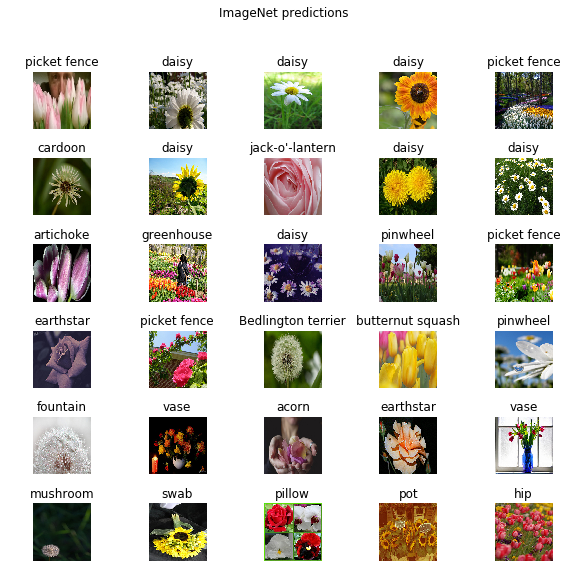

In [22]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [23]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

In [24]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [25]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [26]:
feature_extractor_layer.trainable = False

In [29]:
image_data.num_classes

5

In [61]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten

In [35]:
model = tf.keras.Sequential()
model.add(feature_extractor_layer)
model.add(Dense(image_data.num_classes))

ValueError: Input 0 of layer dense_3 is incompatible with the layer: its rank is undefined, but the layer requires a defined rank.

### New plan, build a model from scratch to test GPU with the flower images

In [62]:
model = tf.keras.models.Sequential()
model.add(Conv2D(128, (3,3), strides=(1,1), 
                              padding='same', 
                              data_format='channels_last', 
                              activation='relu',
                              input_shape=(224,224,3)))
model.add(Conv2D(128, (3,3), strides=(1,1), 
                              padding='same', 
                              data_format='channels_last', 
                              activation='relu'))
model.add(Conv2D(128, (3,3), strides=(1,1), 
                              padding='same', 
                              data_format='channels_last', 
                              activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(256, (3,3), strides=(1,1), 
                              padding='same', 
                              data_format='channels_last', 
                              activation='relu'))
model.add(Conv2D(256, (3,3), strides=(1,1), 
                              padding='same', 
                              data_format='channels_last', 
                              activation='relu'))
model.add(Conv2D(256, (3,3), strides=(1,1), 
                              padding='same', 
                              data_format='channels_last', 
                              activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(512, (3,3), strides=(1,1), 
                              padding='same', 
                              data_format='channels_last', 
                              activation='relu'))
model.add(Conv2D(128, (3,3), strides=(3,3), 
                              padding='same', 
                              data_format='channels_last', 
                              activation='relu'))
model.add(Conv2D(64, (3,3), strides=(3,3), 
                              padding='same', 
                              data_format='channels_last', 
                              activation='relu'))
model.add(Flatten())
model.add(Dense(5))

In [63]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 224, 224, 128)     3584      
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 224, 224, 128)     147584    
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 224, 224, 128)     147584    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 112, 112, 128)     0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 112, 112, 256)     295168    
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 112, 112, 256)     590080    
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 112, 112, 256)   

In [64]:
predictions = model(image_batch)
predictions.shape

TensorShape([32, 5])

In [65]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [66]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

In [67]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

Epoch 1/2
115/115 [==============================] - 115s 1s/step - loss: 1.5919 - acc: 0.4062
Epoch 2/2
115/115 [==============================] - 107s 931ms/step - loss: 1.3499 - acc: 0.4688


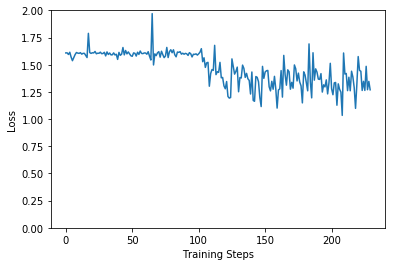

In [68]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

In [69]:
batch_size

NameError: name 'batch_size' is not defined

In [72]:
tf.image.resize(image_batch, size=(112,112)).numpy()

array([[[[2.76470602e-01, 2.64705896e-01, 1.43137261e-01],
         [2.84313738e-01, 2.72549033e-01, 1.50980398e-01],
         [2.89215684e-01, 2.69607842e-01, 1.49019614e-01],
         ...,
         [1.38235301e-01, 1.44117653e-01, 4.90196142e-03],
         [1.52941182e-01, 1.44117653e-01, 1.17647070e-02],
         [1.37254909e-01, 1.34313732e-01, 1.17647070e-02]],

        [[2.84313738e-01, 2.72549033e-01, 1.50980398e-01],
         [2.92156875e-01, 2.80392170e-01, 1.58823535e-01],
         [2.92156875e-01, 2.80392170e-01, 1.49019614e-01],
         ...,
         [1.50000006e-01, 1.45098045e-01, 1.37254912e-02],
         [1.50980398e-01, 1.33333340e-01, 1.27450991e-02],
         [1.34313732e-01, 1.20588243e-01, 3.92156886e-03]],

        [[2.79411793e-01, 2.75490224e-01, 1.57843143e-01],
         [2.82352954e-01, 2.78431386e-01, 1.60784319e-01],
         [2.94117659e-01, 2.82352954e-01, 1.56862751e-01],
         ...,
         [1.59803927e-01, 1.48039222e-01, 2.35294141e-02],
         [

In [ ]:
tf.debugging.